In [1]:
import numpy
from matplotlib import pyplot
from utils import build_banded_matrix, save_simulation
%matplotlib inline

In [2]:
# Domains
X = 1.0
T = 1.0

# Line parameters
R = 3e-3
L = 1e-3
G = 0
C = 1e3

# Derived parameters
c = 1. / numpy.sqrt(L*C)
c_squared = 1. / (L*C)
alpha = (G / C)
beta = (R / L)

omega = 1. / (X * numpy.sqrt(L*C))
freq = 1. / (2 * numpy.pi * X * numpy.sqrt(L*C))

In [3]:
# Discretization
# Spatial domain
K = 99
num_x_points = K + 1
delta_x = X / K
x_domain = numpy.array([0+k*delta_x for k in range(num_x_points)])

# Temporal domain
N = 999
num_t_points = N + 1
delta_t = T / N
t_domain = numpy.array([0+n*delta_t for n in range(num_t_points)])

# CFL criterion
epsilon = c * delta_t / delta_x
print(f"CFL criterion epsilon = {epsilon}")

CFL criterion epsilon = 0.09909909909909909


In [4]:
# Initial conditions
def mu(x):
    return numpy.sin(5*numpy.pi*x) + 2*numpy.sin(7*numpy.pi*x)

def get_u_k_1(u_k_0):
    gamma_0 = 0
    return u_k_0 + gamma_0*delta_t

In [5]:
# Boundary conditions
def nu_0(t):
    return 0.

def nu_X(t):
    return 0.

In [6]:
# Analytic solution
def get_u_x_t(x,t):
    a = 1.5
    def omg(k):
        return numpy.sqrt((c*k*numpy.pi)**2 - a**2)
    
    u = numpy.sin(5*numpy.pi*x) * (numpy.cos(omg(5)*t) + (a/omg(5))*numpy.sin(omg(5)*t))
    u += 2*numpy.sin(7*numpy.pi*x) * (numpy.cos(omg(7)*t) + (a/omg(7))*numpy.sin(omg(7)*t))
    u *= numpy.exp(-a*t)
    
    return u

In [7]:
# Update equation parameters
A = 1. + 0.5 * delta_t * (alpha + beta)
B = 1. - 0.5 * delta_t * (alpha + beta)
E = c_squared * delta_t**2 / delta_x**2
F = 2. - (2. * c_squared * delta_t**2 / delta_x**2) - (alpha * beta * delta_t**2)

E_matrix = build_banded_matrix(numpy.array([E, F, E]), K-1)
B_matrix = B*numpy.concatenate((numpy.zeros((K-1,1)), numpy.identity(K-1), numpy.zeros((K-1,1))), axis=1)

In [8]:
# Container
u_findiffs = numpy.zeros((num_x_points, num_t_points))
u_analytic = numpy.zeros((num_x_points, num_t_points))

In [9]:
# Numerical solution
u_findiffs[:,0] = numpy.array([mu(x) for x in x_domain])
u_findiffs[:,1] = get_u_k_1(u_findiffs[:,0])
u_findiffs[0,0] = nu_0(0)
u_findiffs[K,0] = nu_X(0)

for n in range(1,N):
    u_was, u_now = u_findiffs[:,n-1], u_findiffs[:,n]
    tilde_u_nxt = numpy.dot(E_matrix, u_now) - numpy.dot(B_matrix, u_was)
    tilde_u_nxt /= A
    u_nxt = numpy.concatenate(
        (numpy.array([nu_0(t_domain[n])]), tilde_u_nxt, numpy.array([nu_X(t_domain[n])]))
    )
    u_findiffs[:,n+1] = u_nxt
del n, u_was, u_now, tilde_u_nxt, u_nxt

In [10]:
# Analytic solution
for n in range(num_t_points):
    u_analytic[:,n] = get_u_x_t(x_domain, t_domain[n])
del n

In [11]:
# Time instants to observe
t_stamps_to_observe = [0.05, 0.1, 0.5, 1.0]
n_stamps_to_observe = [numpy.argmin(numpy.abs(t_domain-t_stamp)) for t_stamp in t_stamps_to_observe]

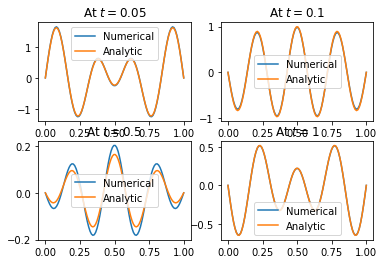

In [12]:
# Visualize stuff
fig = pyplot.figure()
for i, n_stamp_to_observe in enumerate(n_stamps_to_observe):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(x_domain, u_findiffs[:,n_stamp_to_observe], label="Numerical")
    ax.plot(x_domain, u_analytic[:, n_stamp_to_observe], label="Analytic")
    ax.set_title(f"At $t={t_domain[n_stamp_to_observe]:.2g}$")
    ax.legend(loc="best");

In [14]:
# Save simulation
save_simulation(
    {"X" : X, "K" : K, "T" : T, "N" : N, "spatial" : x_domain, "temporal" : t_domain},
    {"R" : 3e-3, "L" : 1e-3, "G" : 0., "C" : 1e3},
    {"A" : A, "B" : B, "E" : E, "F" : F, "E matrix" : E_matrix, "B matrix" : B_matrix},
    {"analytical" : u_analytic, "finite difference" : u_findiffs},
    simulation_id="zhang_eqn25", save_dir="./"
)

Simulation saved to ./zhang_eqn25.pkl.
